In [ ]:
# Download the dataset
#!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation


In [1]:
# The dataset for this project has already been split into a training, validation and test set

# Adding imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image  
%matplotlib inline
from PIL import Image, ImageDraw


In [2]:
# Accessing the dataset in GPU
import os
import zipfile

current_dir = os.getcwd()  # This will be /home/student/deep-machine-learning/home-assignments
zip_file_path = os.path.join(current_dir, 'brain-tumor-image-dataset-semantic-segmentation.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('Dataset_brain')  # Specify the extraction directory

# Now you can access your files in the 'extracted_folder'
print(os.listdir('Dataset_brain'))

['test', 'README.txt', 'valid', 'train']


In [3]:
# prompt: create paths to the train, validation and test images and annotation files
# For GPU
train_path = 'Dataset_brain/train'
val_path = 'Dataset_brain/valid'
test_path = 'Dataset_brain/test'


# You can verify if the paths are correct by printing the content of each directory
#print("Train Images:", os.listdir(train_path))
#print("Validation Images:", os.listdir(val_path))
#print("Test Images:", os.listdir(test_path))


In [4]:
# Loading the images into a list, for this the library os is used and pillow is used to open the images
import os
from PIL import Image
# Initiate the lists
train_images = []
val_images = []
test_images = []


# first load the training images
for file_name in os.listdir(train_path):
    image_path = os.path.join(train_path, file_name)

    # check if it is an image
    if file_name.lower().endswith(('.jpg')):
        img = Image.open(image_path)
        train_images.append(img)

# load the validation images
for file_name in os.listdir(val_path):
    image_path = os.path.join(val_path, file_name)

    # check if it is an image
    if file_name.lower().endswith(('.jpg')):
        img = Image.open(image_path)
        val_images.append(img)

# Load the test images
for file_name in os.listdir(test_path):
    image_path = os.path.join(test_path, file_name)

    # check if it is an image
    if file_name.lower().endswith(('.jpg')):
        img = Image.open(image_path)
        test_images.append(img)

print(len(train_images))
print(len(val_images))
print(len(test_images))

1502
429
215


In [5]:
train_path = Path(train_path)
val_path = Path(val_path)
test_path = Path(test_path)

In [6]:
# Load the annotations of the images, the annotations are in json format
import json

train_annotations_path = train_path / "_annotations.coco.json"
# Load the JSON file
with open(train_annotations_path, 'r') as f:
    train_annotations_data = json.load(f)

val_annotations_path = val_path / "_annotations.coco.json"
# Load the JSON file
with open(val_annotations_path, 'r') as f:
    val_annotations_data = json.load(f)

test_annotations_path = test_path / "_annotations.coco.json"
# Load the JSON file
with open(test_annotations_path, 'r') as f:
    test_annotations_data = json.load(f)

# Test the lengths of the annotations to see if it is the same as the amount of images
print(len(train_annotations_data['annotations']))
print(len(val_annotations_data['annotations']))
print(len(test_annotations_data['annotations']))

1502
429
215


In [7]:
# Print the keys of the dictionary, to get a better feeling of what is inside of the annotations dictionary
print("Keys:", train_annotations_data.keys())

# Print the annotations to look at the structure
annotations_key = next(reversed(train_annotations_data))
print("Annotations:", annotations_key)
first_annotation = train_annotations_data[annotations_key][0]
print("Annotations:", first_annotation)

Keys: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Annotations: annotations
Annotations: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}


In [8]:
from torch.utils.data import Dataset
from pathlib import Path
import json
from PIL import Image

class BrainDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None, return_bbox=True):
        """
        Args:
            images_dir: path to the directory of the images
            annotations_file: path to the JSON file containing COCO style annotations
            transform: optional transform to be applied to the images
            return_bbox: if True, bounding box will also be returned for each sample
        """
        self.images_dir = Path(images_dir)
        self.transform = transform if transform is not None else ToTensor()  # Use ToTensor by default

        self.return_bbox = return_bbox

        # Load the annotations
        with open(annotations_file, 'r') as f:
            self.annotations_data = json.load(f)

        # Collect image file names and their annotations
        self._samples = self._collect_samples()

    def __len__(self):
        """Returns the total number of samples"""
        return len(self._samples)

    def __getitem__(self, index):
        image_file, annotation = self._samples[index]

    # Load the image
        img_path = self.images_dir / image_file
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

    # Apply the transformation if there is any
        if self.transform:
            img = self.transform(img)

    # Get label and bounding box
        label = annotation['category_id']
        bbox = annotation['bbox']

    # Convert bbox to [xmin, ymin, xmax, ymax] format
        xmin, ymin, width, height = bbox
        xmax = xmin + width
        ymax = ymin + height
        bbox = [xmin, ymin, xmax, ymax]

        target = {
            'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),  # Shape [N, 4]
            'labels': torch.tensor([1], dtype=torch.int64)  # Ensure labels are 0 or 1 for two classes
        }
        return img, target

    def _collect_samples(self):
        """Helper function to collect samples"""
        samples = []

        # COCO annotations contain a list of images and annotations
        image_id_to_file = {img['id']: img['file_name'] for img in self.annotations_data['images']}
        for annotation in self.annotations_data['annotations']:
            image_id = annotation['image_id']
            if image_id in image_id_to_file:
                image_file = image_id_to_file[image_id]
                samples.append((image_file, annotation))

        return samples

    def get_sample_by_image_id(self, image_id):
        """Get a sample by its image ID."""
        for index, (image_file, annotation) in enumerate(self._samples):
            if annotation['image_id'] == image_id:
                return self[index]
        raise ValueError(f"No sample found with image ID: {image_id}")



In [9]:
# Create datasets
train_dataset = BrainDataset(train_path, train_annotations_path, transform = None, return_bbox = True)
val_dataset = BrainDataset(val_path, val_annotations_path, transform = None, return_bbox = True)
test_dataset = BrainDataset(test_path, test_annotations_path, transform = None, return_bbox = True)


In [10]:
# Define dataloaders
from torch.utils.data import DataLoader

# Define bach size
batch_size = 8

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


In [11]:

# Create an instance of BrainDataset
example_dataset = BrainDataset(train_path, train_annotations_path, transform= None, return_bbox = True)

# Get the number of samples in the dataset
number_of_samples = len(example_dataset)

# Get the label of the second sample
img, bbox = example_dataset[1]

# Print the results
print(f"The number of samples is: {number_of_samples}")

print(f"The bounding box of the second sample is: {bbox}")

The number of samples is: 1502
The bounding box of the second sample is: {'boxes': tensor([[194.0000, 176.0000, 342.7500, 409.7500]]), 'labels': tensor([1])}


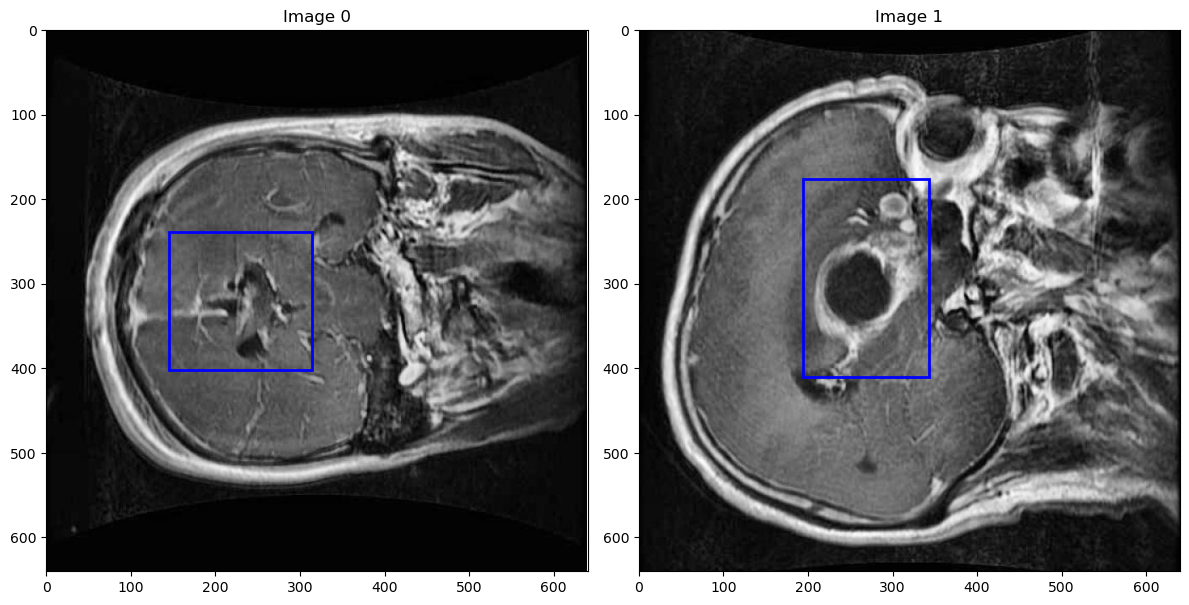

In [12]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor

def display_image_with_bbox(axis, image_tensor, bbox=None):
    """Display a tensor as an image with an optional bounding box.

    Args:
        axis (pyplot axis): The axis to draw the image on.
        image_tensor (torch.Tensor): Tensor with shape (num_channels=3, width, height).
        bbox (list or None): Optional bounding box in the format [xmin, ymin, xmax, ymax] or [x, y, width, height].
    """
    # Check if the input is a tensor
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor` "
            + "use the `ToTensor` transformation to convert the images to tensors."
        )

    # Prepare the image for display
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape

    # Display the image
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)

    # Draw the bounding box if provided
    if bbox is not None:
        # Check if bbox is a tensor and has the shape (1, 4), then extract it
        if isinstance(bbox, torch.Tensor) and bbox.shape == (1, 4):
            bbox = bbox.squeeze().tolist()
        elif isinstance(bbox, torch.Tensor):
            bbox = bbox.tolist()

        # If the bbox is in [xmin, ymin, xmax, ymax], convert it to [x, y, width, height]
        if len(bbox) == 4:
            xmin, ymin, xmax, ymax = bbox
            bbox = [xmin, ymin, xmax - xmin, ymax - ymin]

        # Draw the bounding box
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=2)
        axis.add_patch(rect)

def display_two_images(dataset, index1, index2):
    """Display two images from the dataset with their corresponding bounding boxes.

    Args:
        dataset: The dataset from which to retrieve images.
        index1 (int): Index of the first image.
        index2 (int): Index of the second image.
    """
    _, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Get the first image and its target dictionary
    img1, target1 = dataset[index1]
    bbox1 = target1['boxes']
    display_image_with_bbox(axes[0], img1, bbox=bbox1)
    axes[0].set_title(f"Image {index1}")

    # Get the second image and its target dictionary
    img2, target2 = dataset[index2]
    bbox2 = target2['boxes']
    display_image_with_bbox(axes[1], img2, bbox=bbox2)
    axes[1].set_title(f"Image {index2}")

    plt.tight_layout()
    plt.show()

# Example usage
example_dataset = BrainDataset(train_path, train_annotations_path, transform=ToTensor(), return_bbox=True)
display_two_images(example_dataset, 0, 1)  # Display the first two images with their bounding boxes



## **Models used in the different Papers**

1.Accordingly, the ***UNet and 3D-UNet*** are also very common CNN applications for medical image analysis. Structure of the UNet involves encoder-decoder; low-level features are learned by encoder part while high-level features are learned by the decoder with the features obtained from an encoder. This architecture can be described as an end-to-end network and be able to generate significant results in medical image segmentation

From [Karayegen G, Aksahin MF. Brain tumor prediction on MR images with semantic segmentation by
using deep learning network and 3D imaging of tumor region. Biomedical Signal Processing and
Control. 2021;66:102458. Available from: https://www.sciencedirect.com/science/article/pii/
S1746809421000550]

 2.In this paper, we tackle this problem by applying a fully convolutional neural network **SegNet **to 3D data sets for four MRI modalities (Flair, T1, T1ce, and T2) for automated segmentation of brain tumor and subtumor parts, including necrosis, edema, and enhancing tumor.

 From [Alqazzaz S, Sun X, Yang X, Nokes L. Automated brain tumor segmentation on multi-modal MR
image using SegNet. Computational Visual Media. 2019 Jun;5(2):209-19. Available from: http:
//link.springer.com/10.1007/s41095-019-0139-y.]

3.The present study proposes a new deep learning generator architecture called ***Attention Res-UNet with Guided Decoder (ARU-GD)***for the segmentation of brain tumors.

from [aji D, Sigedar P, Singh M. Attention Res-UNet with Guided Decoder for semantic segmentation of
brain tumors. Biomedical Signal Processing and Control. 2022 Jan;71:103077. Available from: https:
//linkinghub.elsevier.com/retrieve/pii/S1746809421006741]

In [13]:
#Changed Braindataset

from torch.utils.data import Dataset
from pathlib import Path
import json
from PIL import Image, ImageDraw
import torch
import numpy as np
import torchvision.transforms.functional as TF

class BrainDataset(Dataset):
    """
    Custom dataset for brain images with COCO-style annotations.

    Attributes:
        images_dir (Path): Path to the directory of the images.
        transform (callable): Transform to be applied to the images.
        annotations_data (dict): Parsed annotation data from JSON file.
        segmentation (list): List of segmentation points from the annotation.
        polygon (list): Polygon created from segmentation points.
    """

    def __init__(self, images_dir, annotations_file, transform=None):
        """
        Args:
            images_dir (str): Path to the directory of the images.
            annotations_file (str): Path to the JSON file containing COCO-style annotations.
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.images_dir = Path(images_dir)
        self.transform = transform if transform is not None else None  # Use default transform if provided

        # Load the annotations
        with open(annotations_file, 'r') as f:
            self.annotations_data = json.load(f)

        # Collect image file names and their annotations
        self._samples = self._collect_samples()

    def __len__(self):
        """Returns the total number of samples."""
        return len(self._samples)

    def __getitem__(self, index):
        image_file, annotation = self._samples[index]

        # Load the image
        img_path = self.images_dir / image_file
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

        # Get the image size
        img_size = img.size  # (width, height)

        # Apply the transformation if there is any
        if self.transform:
            img = self.transform(img)

        # Get the segmentation mask
        mask = self.create_mask(annotation, img_size)  # Pass image size

        target = {
            'boxes': torch.tensor([[annotation['bbox'][0], annotation['bbox'][1],
                                    annotation['bbox'][0] + annotation['bbox'][2],
                                    annotation['bbox'][1] + annotation['bbox'][3]]], dtype=torch.float32),  # Shape [N, 4]
            'labels': torch.tensor([annotation['category_id']], dtype=torch.int64)  # Ensure labels are correct for classes
        }

        return {'image': img, 'mask': mask, 'target': target}  # Return a dictionary with image, mask, and target

    def create_mask(self, annotation, img_size):
        """
        Create a binary mask for the segmentation.

        Args:
            annotation (dict): COCO-style annotation for the image.
            img_size (tuple): Size of the image (width, height).

        Returns:
            torch.Tensor: Binary mask tensor.
        """
        # Create a black mask with the same dimensions as the input image
        mask = Image.new('L', img_size, 0)

        # Check if 'segmentation' exists in the annotation
        if 'segmentation' in annotation:
            for segmentation in annotation['segmentation']:
                # Convert segmentation from COCO format to a polygon on the mask
                polygon = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
                # Draw the polygon on the mask
                ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
        mask = TF.resize(mask, (256, 256))
        # Convert mask to tensor
        return torch.tensor(np.array(mask), dtype=torch.float32)

    def _collect_samples(self):
        """Helper function to collect samples with corresponding annotations."""
        samples = []
        image_id_to_file = {img['id']: img['file_name'] for img in self.annotations_data['images']}
        for annotation in self.annotations_data['annotations']:
            image_id = annotation['image_id']
            if image_id in image_id_to_file:
                image_file = image_id_to_file[image_id]
                samples.append((image_file, annotation))
        return samples


In [ ]:
# Augmentation
from torch.utils.data import Dataset
from pathlib import Path
import json
from PIL import Image, ImageDraw
import torch
import numpy as np
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import random

class BrainDataset(Dataset):
    """
    Custom dataset for brain images with COCO-style annotations.
    """

    def __init__(self, images_dir, annotations_file, transform=None):
        """
        Args:
            images_dir (str): Path to the directory of the images.
            annotations_file (str): Path to the JSON file containing COCO-style annotations.
            transform (callable, optional): Optional transform to be applied to the images and masks.
        """
        self.images_dir = Path(images_dir)
        self.transform = transform if transform is not None else None  # Use default transform if provided

        # Load the annotations
        with open(annotations_file, 'r') as f:
            self.annotations_data = json.load(f)

        # Collect image file names and their annotations
        self._samples = self._collect_samples()

    def __len__(self):
        """Returns the total number of samples."""
        return len(self._samples)

    def __getitem__(self, index):
        image_file, annotation = self._samples[index]

        # Load the image
        img_path = self.images_dir / image_file
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

        # Get the image size
        img_size = img.size  # (width, height)

        # Get the segmentation mask
        mask = self.create_mask(annotation, img_size)  # Pass image size

        # Apply the transformation if there is any
        if self.transform:
            img, mask = self.transform(img, mask)  # Apply transformation to both img and mask

        # Prepare the target information
        target = {
            'boxes': torch.tensor([[annotation['bbox'][0], annotation['bbox'][1],
                                    annotation['bbox'][0] + annotation['bbox'][2],
                                    annotation['bbox'][1] + annotation['bbox'][3]]], dtype=torch.float32),  # Shape [N, 4]
            'labels': torch.tensor([annotation['category_id']], dtype=torch.int64)  # Ensure labels are correct for classes
        }

        return {'image': img, 'mask': mask, 'target': target}  # Return a dictionary with image, mask, and target

    def create_mask(self, annotation, img_size):
        """
        Create a binary mask for the segmentation.
        """
        # Create a black mask with the same dimensions as the input image
        mask = Image.new('L', img_size, 0)

        # Check if 'segmentation' exists in the annotation
        if 'segmentation' in annotation:
            for segmentation in annotation['segmentation']:
                # Convert segmentation from COCO format to a polygon on the mask
                polygon = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
                # Draw the polygon on the mask
                ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)

        # Resize mask to match the input size
        mask = TF.resize(mask, (256, 256))
        # Convert mask to tensor
        return torch.tensor(np.array(mask), dtype=torch.float32)

    def _collect_samples(self):
        """Helper function to collect samples with corresponding annotations."""
        samples = []
        image_id_to_file = {img['id']: img['file_name'] for img in self.annotations_data['images']}
        for annotation in self.annotations_data['annotations']:
            image_id = annotation['image_id']
            if image_id in image_id_to_file:
                image_file = image_id_to_file[image_id]
                samples.append((image_file, annotation))
        return samples

# Custom augmentation class
class SegmentationAugmentation:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.2  # Ensure this value is handled correctly
            )
        ])

    def __call__(self, img, mask):
        # Print out the current state for debugging
        print("Applying transformations...")

        # Ensure img is a tensor or PIL Image
        img = TF.to_tensor(img)

        # Apply transformations to the image
        img = self.transforms(img)

        # Apply the same transformations to the mask (only resizing)
        mask = TF.resize(mask, (256, 256))  # Ensure mask is resized accordingly

        return img, mask
# Example usage
# Assuming you have your images and annotations ready
# images_dir = "path/to/images"
# annotations_file = "path/to/annotations.json"
# dataset = BrainDataset(images_dir, annotations_file, transform=SegmentationAugmentation())


**UNet Model**
  
  1.Upsampling Layers: The input channels for each upsampling (upconv_block) layer now account for the concatenation.
  For instance: self.upconv4 takes input with 1024 + 512 channels after concatenating the bottleneck output (1024 channels) with the corresponding encoder output (enc4, which has 512 channels).
  Similarly, self.upconv3 takes input with 512 + 256 channels, and so on.
  
  Concatenation: The torch.cat operation in the forward pass concatenates the upsampled decoder output with the corresponding encoder output. This doubles the number of channels, so the next layer must expect that.

Explanation of Concatenation:
In U-Net, the output of each downsampling step (from the encoder) is concatenated with the corresponding upsampling step (from the decoder). This helps retain spatial information lost during downsampling. Since the concatenation doubles the number of channels, the input to the next ConvTranspose2d layer must account for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetEnhanced(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(UNetEnhanced, self).__init__()
        self.dropout_rate = dropout_rate

        # Downsampling (encoder)
        self.enc1 = self.contract_block(in_channels, 64, dropout_rate)
        self.enc2 = self.contract_block(64, 128, dropout_rate)
        self.enc3 = self.contract_block(128, 256, dropout_rate)
        self.enc4 = self.contract_block(256, 512, dropout_rate)
        self.bottleneck = self.contract_block(512, 1024, dropout_rate)

        # Upsampling (decoder)
        self.upconv4 = self.expand_block(1024 + 512, 512, dropout_rate)
        self.upconv3 = self.expand_block(512 + 256, 256, dropout_rate)
        self.upconv2 = self.expand_block(256 + 128, 128, dropout_rate)
        self.upconv1 = self.expand_block(128 + 64, 64, dropout_rate)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels, dropout_rate):
        """Downsampling block: Residual Connection, conv -> batchnorm -> LeakyReLU -> conv -> batchnorm -> LeakyReLU -> dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def expand_block(self, in_channels, out_channels, dropout_rate):
        """Upsampling block: Interpolation -> conv -> batchnorm -> LeakyReLU -> dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder (upsampling)
        dec4 = self.upconv4(torch.cat((bottleneck, F.interpolate(enc4, bottleneck.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec3 = self.upconv3(torch.cat((dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec2 = self.upconv2(torch.cat((dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec1 = self.upconv1(torch.cat((dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear', align_corners=False)), dim=1))

        output = self.final_conv(dec1)
        output = F.interpolate(output, size=x.size()[2:], mode='bilinear', align_corners=False)


        # Final convolution layer to get the desired number of output channels
        return output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # Channel reduction for gating and skip connections
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Upsample g to the same size as x
        if g.size() != x.size():
            g = F.interpolate(g, size=x.size()[2:], mode='bilinear', align_corners=False)

        # Apply the gating signal
        g1 = self.W_g(g)
        # Apply to the skip connection
        x1 = self.W_x(x)
        # Combine the gating signal and the skip connection
        psi = self.relu(g1 + x1)
        # Get the attention map
        psi = self.psi(psi)
        # Multiply the input by the attention map
        return x * psi


class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(UNetWithAttention, self).__init__()
        self.dropout_rate = dropout_rate

        # Downsampling (encoder)
        self.enc1 = self.contract_block(in_channels, 64, dropout_rate)
        self.enc2 = self.contract_block(64, 128, dropout_rate)
        self.enc3 = self.contract_block(128, 256, dropout_rate)
        self.enc4 = self.contract_block(256, 512, dropout_rate)
        self.bottleneck = self.contract_block(512, 1024, dropout_rate)

        # Attention layers
        self.att4 = AttentionBlock(F_g=1024, F_l=512, F_int=256)
        self.att3 = AttentionBlock(F_g=512, F_l=256, F_int=128)
        self.att2 = AttentionBlock(F_g=256, F_l=128, F_int=64)
        self.att1 = AttentionBlock(F_g=128, F_l=64, F_int=32)

        # Upsampling (decoder)
        self.upconv4 = self.upconv_block(1024 + 512, 512, dropout_rate)
        self.upconv3 = self.upconv_block(512 + 256, 256, dropout_rate)
        self.upconv2 = self.upconv_block(256 + 128, 128, dropout_rate)
        self.upconv1 = self.upconv_block(128 + 64, 64, dropout_rate)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels, dropout_rate):
        """Downsampling block: conv -> batchnorm -> ReLU -> conv -> batchnorm -> ReLU -> dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def upconv_block(self, in_channels, out_channels, dropout_rate):
        """Upsampling block with transposed convolution followed by dropout"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder (upsampling) with attention
        att4 = self.att4(g=bottleneck, x=enc4)  # Apply attention to enc4

        # Make sure att4 matches the spatial dimensions of the bottleneck
        if att4.size(2) != bottleneck.size(2) or att4.size(3) != bottleneck.size(3):
            att4 = F.interpolate(att4, size=(bottleneck.size(2), bottleneck.size(3)), mode='bilinear', align_corners=False)

        dec4 = self.upconv4(torch.cat((bottleneck, att4), dim=1))

        att3 = self.att3(g=dec4, x=enc3)  # Apply attention to enc3
        # Make sure att3 matches the spatial dimensions of dec4
        if att3.size(2) != dec4.size(2) or att3.size(3) != dec4.size(3):
            att3 = F.interpolate(att3, size=(dec4.size(2), dec4.size(3)), mode='bilinear', align_corners=False)    
        dec3 = self.upconv3(torch.cat((dec4, att3), dim=1))

        att2 = self.att2(g=dec3, x=enc2)  # Apply attention to enc2
        if att2.size(2) != dec3.size(2) or att2.size(3) != dec3.size(3):
            att2 = F.interpolate(att2, size=(dec3.size(2), dec3.size(3)), mode='bilinear', align_corners=False)
        dec2 = self.upconv2(torch.cat((dec3, att2), dim=1))

        att1 = self.att1(g=dec2, x=enc1)  # Apply attention to enc1
        if att1.size(2) != dec2.size(2) or att1.size(3) != dec2.size(3):
            att1 = F.interpolate(att1, size=(dec2.size(2), dec2.size(3)), mode='bilinear', align_corners=False)
        dec1 = self.upconv1(torch.cat((dec2, att1), dim=1))

        # Final convolution layer to get the desired number of output channels
        return self.final_conv(dec1)




In [14]:
class DeeperUNetWithDropout(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super(DeeperUNetWithDropout, self).__init__()
        self.dropout_rate = dropout_rate

        # Downsampling (encoder)
        self.enc1 = self.contract_block(in_channels, 128, dropout_rate)
        self.enc2 = self.contract_block(128, 256, dropout_rate)
        self.enc3 = self.contract_block(256, 512, dropout_rate)
        self.enc4 = self.contract_block(512, 1024, dropout_rate)
        self.enc5 = self.contract_block(1024, 2048, dropout_rate)  # Additional encoder block
        self.bottleneck = self.contract_block(2048, 4096, dropout_rate)

        # Upsampling (decoder)
        self.upconv5 = self.upconv_block(4096 + 2048, 2048, dropout_rate)  # Additional decoder block
        self.upconv4 = self.upconv_block(2048 + 1024, 1024, dropout_rate)
        self.upconv3 = self.upconv_block(1024 + 512, 512, dropout_rate)
        self.upconv2 = self.upconv_block(512 + 256, 256, dropout_rate)
        self.upconv1 = self.upconv_block(256 + 128, 128, dropout_rate)

        # Final output layer
        self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels, dropout_rate):
        """Downsampling block: conv -> batchnorm -> ReLU -> conv -> batchnorm -> ReLU -> dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Adding dropout layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels, dropout_rate):
        """Upsampling block with transposed convolution followed by dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout_rate)  # Adding dropout here as well
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        enc5 = self.enc5(F.max_pool2d(enc4, kernel_size=2))  # Additional encoder layer
        bottleneck = self.bottleneck(F.max_pool2d(enc5, kernel_size=2))

        # Decoder (upsampling)
        dec5 = self.upconv5(torch.cat((bottleneck, F.interpolate(enc5, bottleneck.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec4 = self.upconv4(torch.cat((dec5, F.interpolate(enc4, dec5.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec3 = self.upconv3(torch.cat((dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec2 = self.upconv2(torch.cat((dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec1 = self.upconv1(torch.cat((dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear', align_corners=False)), dim=1))

        # Final convolution layer to get the desired number of output channels
        return self.final_conv(dec1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithDropout(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(UNetWithDropout, self).__init__()
        self.dropout_rate = dropout_rate

        # Downsampling (encoder)
        self.enc1 = self.contract_block(in_channels, 128, dropout_rate)
        self.enc2 = self.contract_block(128, 256, dropout_rate)
        self.enc3 = self.contract_block(256, 512, dropout_rate)
        self.enc4 = self.contract_block(512, 1024, dropout_rate)
        self.bottleneck = self.contract_block(1024, 2048, dropout_rate)

        # Upsampling (decoder)
        # Notice the input channels for upsampling blocks are doubled due to concatenation
        self.upconv4 = self.upconv_block(2048 + 1024, 1024, dropout_rate)
        self.upconv3 = self.upconv_block(1024 + 512, 512, dropout_rate)
        self.upconv2 = self.upconv_block(512 + 256, 256, dropout_rate)
        self.upconv1 = self.upconv_block(256 + 128, 128, dropout_rate)

        # Final output layer
        self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels, dropout_rate):
        """Downsampling block: conv -> batchnorm -> ReLU -> conv -> batchnorm -> ReLU -> dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Adding dropout layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels, dropout_rate):
        """Upsampling block with transposed convolution followed by dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding =1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size = 2, stride = 2),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout_rate)  # Adding dropout here as well
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder (upsampling)
        dec4 = self.upconv4(torch.cat((bottleneck, F.interpolate(enc4, bottleneck.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec3 = self.upconv3(torch.cat((dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec2 = self.upconv2(torch.cat((dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec1 = self.upconv1(torch.cat((dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear', align_corners=False)), dim=1))

        # Final convolution layer to get the desired number of output channels
        return self.final_conv(dec1)



In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (encoder)
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)
        self.bottleneck = self.contract_block(512, 1024)

        # Upsampling (decoder)
        # Notice the input channels for upsampling blocks are doubled due to concatenation
        self.upconv4 = self.upconv_block(1024 + 512, 512)  # Concatenation, so input is 1024 + 512
        self.upconv3 = self.upconv_block(512 + 256, 256)
        self.upconv2 = self.upconv_block(256 + 128, 128)
        self.upconv1 = self.upconv_block(128 + 64, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        """Downsampling block: conv -> batchnorm -> ReLU -> conv -> batchnorm -> ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with transposed convolution"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder (upsampling)
        # Resize encoder feature maps to match the upsampled decoder feature maps
        dec4 = self.upconv4(torch.cat((bottleneck, F.interpolate(enc4, bottleneck.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec3 = self.upconv3(torch.cat((dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec2 = self.upconv2(torch.cat((dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear', align_corners=False)), dim=1))
        dec1 = self.upconv1(torch.cat((dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear', align_corners=False)), dim=1))

        # Final convolution layer to get the desired number of output channels
        return self.final_conv(dec1)


Overall Flow of the U-Net:

Encoder (Downsampling): The input image goes through a series of convolutional layers and pooling operations, progressively reducing its spatial dimensions while increasing the number of feature channels.

Bottleneck: The deepest part of the network where the most abstracted features are captured.

Decoder (Upsampling): The feature maps are progressively upsampled back to the original input size. During this process, the feature maps from the encoder are concatenated with the decoder via skip connections, helping retain spatial information that might be lost during downsampling.

Final Output: The output is a mask (or segmented image) of the same spatial size as the input but with out_channels (e.g., 1 for binary segmentation).

In [15]:
# Custom diceBCELoss function
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, masks):
        # Apply sigmoid activation to outputs
        outputs = torch.sigmoid(outputs)
        # Flatten outputs and masks
        outputs = outputs.view(-1)
        masks = masks.view(-1)
        # Calculate Dice coefficient
        intersection = (outputs * masks).sum()
        dice = (2. * intersection + self.smooth) / (outputs.sum() + masks.sum() + self.smooth)
        # BCE Loss
        bce = F.binary_cross_entropy_with_logits(outputs, masks.float(), reduction='mean')
        # Combined Dice and BCE Loss
        dice_bce_loss = 1 - dice + bce
        return dice_bce_loss


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid activation to the logits
        logits = torch.sigmoid(logits)
        
        # Flatten the tensors
        logits = logits.view(-1)
        targets = targets.view(-1)
        
        # Calculate Dice score
        intersection = (logits * targets).sum()
        dice_score = (2.0 * intersection + self.smooth) / (logits.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss
        return 1.0 - dice_score

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        # Apply sigmoid activation to the logits
        logits = torch.sigmoid(logits)
        
        # Flatten the tensors
        logits = logits.view(-1)
        targets = targets.view(-1)
        
        # Compute the binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(logits, targets, reduction='mean')
        
        # Compute the focal loss scaling factor
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        return focal_loss

class CombinedDiceFocalLoss(nn.Module):
    def __init__(self, dice_weight=0.7, focal_weight=0.3):
        super(CombinedDiceFocalLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, logits, targets):
        # Calculate Dice loss
        dice_loss = self.dice_loss(logits, targets)
        
        # Calculate Focal loss
        focal_loss = self.focal_loss(logits, targets)
        
        # Combine the losses with the given weights
        loss = self.dice_weight * dice_loss + self.focal_weight * focal_loss
        return loss






Epoch [1/50], Training Loss: 0.6622, Validation Loss: 2.3697, IoU: 0.1195
Epoch [2/50], Training Loss: 0.6906, Validation Loss: 3.2208, IoU: 0.1020
Epoch [3/50], Training Loss: 0.6889, Validation Loss: 1.0080, IoU: 0.3416
Epoch [4/50], Training Loss: 0.7250, Validation Loss: 0.6625, IoU: 0.3498
Epoch [5/50], Training Loss: 0.6714, Validation Loss: 0.5036, IoU: 0.2704
Epoch [6/50], Training Loss: 0.5946, Validation Loss: 0.5005, IoU: 0.3837
Epoch [7/50], Training Loss: 0.5302, Validation Loss: 0.9451, IoU: 0.3565
Epoch [8/50], Training Loss: 0.4796, Validation Loss: 0.3785, IoU: 0.4391
Epoch [9/50], Training Loss: 0.4244, Validation Loss: 0.3688, IoU: 0.4590
Epoch [10/50], Training Loss: 0.3908, Validation Loss: 0.3517, IoU: 0.4780
Epoch [11/50], Training Loss: 0.3606, Validation Loss: 0.6246, IoU: 0.3851
Epoch [12/50], Training Loss: 0.3370, Validation Loss: 0.2953, IoU: 0.4891
Epoch [13/50], Training Loss: 0.3019, Validation Loss: 0.3407, IoU: 0.4918
Epoch [14/50], Training Loss: 0.30

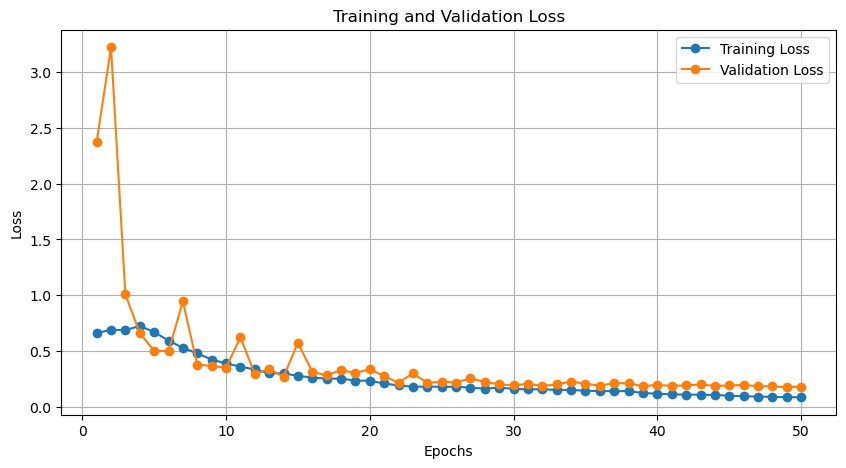

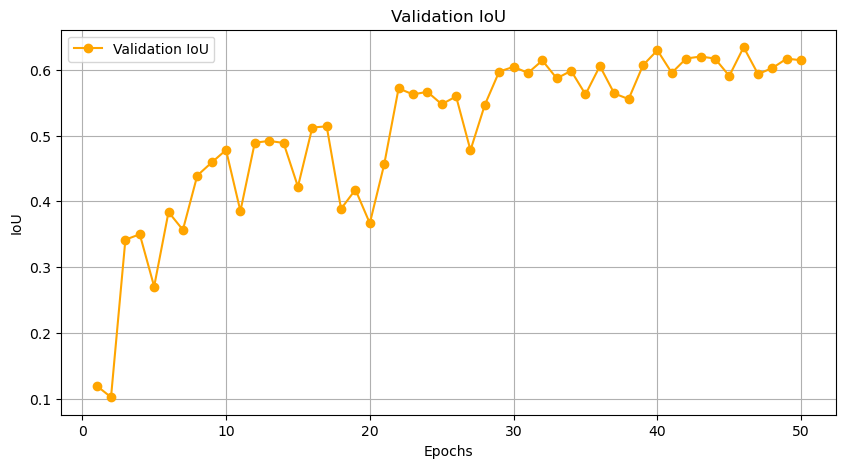

In [17]:
#Calculation of validation loss,training loss and IoU

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T


def calculate_iou(outputs, masks, threshold=0.5):
    """Calculate the Intersection over Union (IoU) for a batch of images."""
    # Apply sigmoid to model outputs to get probabilities
    probs = torch.sigmoid(outputs)

    # Apply the threshold to get binary predictions
    preds = (probs > threshold).float()

    # Flatten the tensors
    preds = preds.view(-1)
    masks = masks.view(-1)

    # Calculate intersection and union
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    iou = intersection / union
    return iou.item()

def validate_unet(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_iou = 0.0
    #criterion = nn.BCEWithLogitsLoss()
    criterion = CombinedDiceFocalLoss(dice_weight=0.7, focal_weight=0.3)

    with torch.no_grad():  # Disable gradient tracking
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device).float()

            # Resize masks to match model output size
            masks = nn.functional.interpolate(masks.unsqueeze(1), size=(256, 256), mode='bilinear', align_corners=False).squeeze(1)

            # Get model outputs
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))  # Ensure masks have the same shape as outputs

            running_loss += loss.item()

            # Calculate IoU
            batch_iou = calculate_iou(outputs, masks.unsqueeze(1))  # Ensure masks are of the same shape
            total_iou += batch_iou

    # Calculate average validation loss and IoU
    avg_val_loss = running_loss / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    return avg_val_loss, avg_iou

def train_unet(model, train_loader, val_loader, num_epochs, device, optimizer, scheduler):
    model.to(device)
    #criterion = DiceBCELoss()
    criterion = CombinedDiceFocalLoss(dice_weight=0.7, focal_weight=0.3)

    train_losses = []
    val_losses = []
    val_ious = []  # List to store IoU values

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device).float()

            # Resize masks to match model output size
            masks = nn.functional.interpolate(masks.unsqueeze(1), size=(256, 256), mode='bilinear', align_corners=False).squeeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))  # Ensure masks have the same shape as outputs
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate the model
        avg_val_loss, avg_iou = validate_unet(model, val_loader, device)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_iou)  # Store IoU value

        # Step the scheduler based on the validation loss
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}")

    print("Training complete.")
    return model, train_losses, val_losses, val_ious  # Return IoU as well



# Define the parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 1  # For binary segmentation (tumor vs. background)
num_epochs = 50
batch_size = 16
learning_rate = 1e-4
#model = UNetWithDropout(in_channels=3, out_channels=1, dropout_rate=0.1).to(device)
#model = UNetWithAttention(in_channels=3, out_channels=1, dropout_rate=0.3)
#model = UNetEnhanced(in_channels = 3, out_channels = 1, dropout_rate = 0.3)
model = DeeperUNetWithDropout(in_channels=3, out_channels=1, dropout_rate=0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # Adjust weight decay value as needed

# Add a learning rate scheduler
from torch.optim.lr_scheduler import CyclicLR
#scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=5, mode='triangular', cycle_momentum=False)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-6)


# Data transformations
transform = T.Compose([
    T.Resize((256, 256)),  # Resize images to a fixed size if needed
    T.ToTensor(),  # Convert images to tensors
])
# Initialize the U-Net model
#model = UNet(in_channels=3, out_channels=num_classes)  # Assuming RGB images
#model = UNetWithDropout(in_channels=3, out_channels=1, dropout_rate=0.3).to(device)


# Assuming you have a dataset that outputs images and masks
train_dataset = BrainDataset(train_path, train_annotations_path, transform=transform)
val_dataset = BrainDataset(val_path, val_annotations_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Assuming you have your datasets and data loaders set up correctly
trained_model, train_losses, val_losses, val_ious = train_unet(model = model, 
                                                               train_loader = train_loader, 
                                                               val_loader = val_loader, 
                                                               num_epochs = num_epochs, 
                                                               device = device,
                                                               optimizer = optimizer,
                                                               scheduler = scheduler)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the validation IoU
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU', marker='o', color='orange')
plt.title('Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid()
plt.show()


In [29]:
# Testing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
batch_size = 16
# Assuming BrainDataset and your model (unet_model) are already defined
# Define your test dataset and data loader
test_dataset = BrainDataset(test_path, test_annotations_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No custom collate_fn

# Test function to evaluate the model on the test dataset
def test_unet(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    ground_truths = []

    with torch.no_grad():  # Disable gradient tracking
        for batch in test_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device).float()

            # Resize masks to match model output size
            masks = nn.functional.interpolate(masks.unsqueeze(1), size=(256, 256), mode='bilinear', align_corners=False).squeeze(1)

            # Get model outputs
            outputs = model(images)

            # Convert outputs to probabilities
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = (preds > 0.5).float()  # Binarize the predictions

            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(masks.cpu().numpy())

    return predictions, ground_truths

# Function to visualize predictions

def visualize_results(test_images, ground_truths, predictions):
    num_images = len(test_images)

    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(test_images[i].transpose(1, 2, 0))  # Assuming images are in CHW format
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        # Ensure ground_truths[i] is 2D, shape should be (H, W)
        ground_truth_mask = ground_truths[i].squeeze() if ground_truths[i].ndim > 2 else ground_truths[i]
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        # Ensure predictions[i] is 2D, shape should be (H, W)
        predicted_mask = predictions[i].squeeze() if predictions[i].ndim > 2 else predictions[i]
        plt.imshow(predicted_mask, cmap='gray')  # Display predicted mask
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



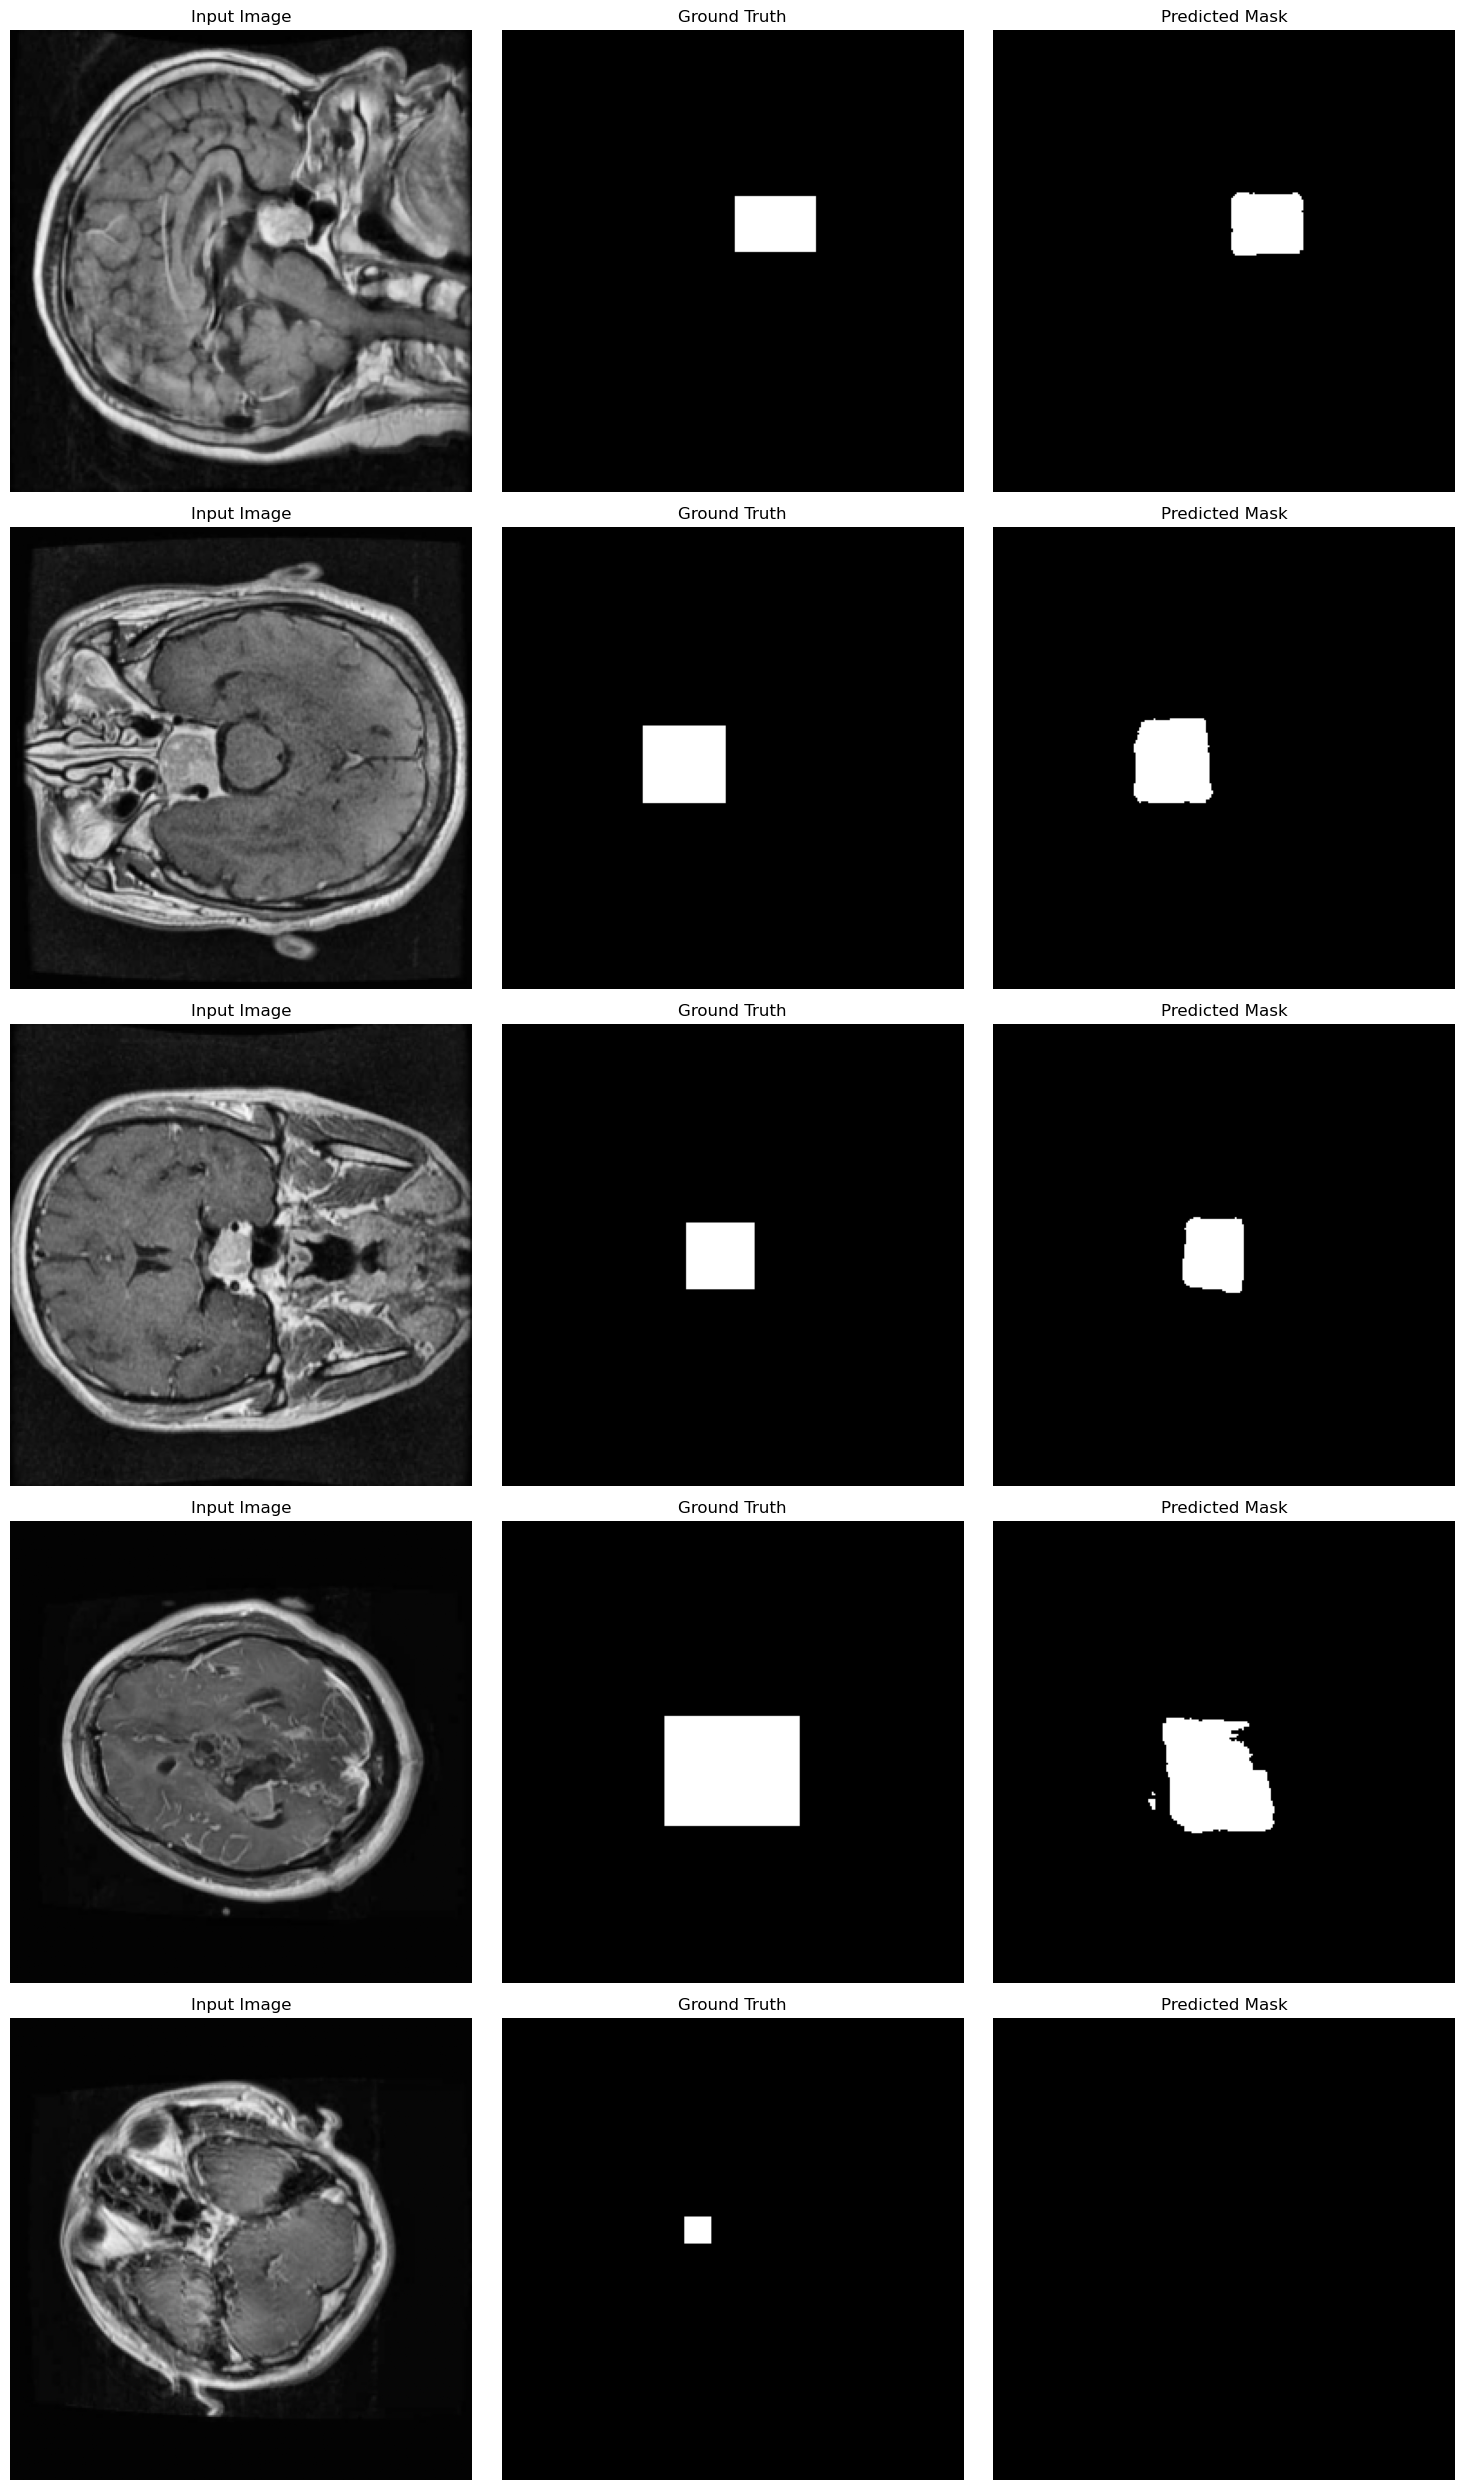

In [30]:

# Load the trained model (make sure it's on the right device)
trained_model.to(device)

# Test the model on the test dataset
predictions, ground_truths = test_unet(trained_model, test_loader, device)

# Visualize the results (show first 5 results for brevity)
num_visualize = 5
visualize_results(
    [test_dataset.__getitem__(i)['image'].numpy() for i in range(num_visualize)],  # Change to list comprehension
    ground_truths[:num_visualize],
    predictions[:num_visualize]
)

In [31]:
import numpy as np
import torch

def global_accuracy(predictions, ground_truths):
    """Calculate the global accuracy of the predictions."""
    correct_pixels = np.sum(np.array(predictions) == np.array(ground_truths))
    total_pixels = np.prod(np.array(ground_truths).shape)
    return correct_pixels / total_pixels

def mean_accuracy(predictions, ground_truths, num_classes=1):
    """Calculate the mean accuracy for each class."""
    accuracies = []
    for cls in range(num_classes):
        true_positive = np.sum((np.array(predictions) == cls) & (np.array(ground_truths) == cls))
        total_pixels = np.sum(np.array(ground_truths) == cls)
        if total_pixels > 0:
            accuracies.append(true_positive / total_pixels)
    return np.mean(accuracies)

def intersection_over_union(predictions, ground_truths, num_classes=1):
    """Calculate the mean and weighted IoU."""
    iou_list = []
    for cls in range(num_classes):
        intersection = np.sum((np.array(predictions) == cls) & (np.array(ground_truths) == cls))
        union = np.sum(np.array(predictions) == cls) + np.sum(np.array(ground_truths) == cls) - intersection
        if union > 0:
            iou = intersection / union
            iou_list.append(iou)
        else:
            iou_list.append(0.0)
    mean_iou = np.mean(iou_list)
    weighted_iou = np.sum(iou_list) / num_classes
    return mean_iou, weighted_iou

def f_score(predictions, ground_truths, beta=1):
    """Calculate the mean F-score."""
    true_positive = np.sum((np.array(predictions) == 1) & (np.array(ground_truths) == 1))
    false_positive = np.sum((np.array(predictions) == 1) & (np.array(ground_truths) == 0))
    false_negative = np.sum((np.array(predictions) == 0) & (np.array(ground_truths) == 1))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    if precision + recall == 0:
        return 0.0
    f1_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    return f1_score

def dice_score(predictions, ground_truths):
    """Calculate the Dice score."""
    true_positive = np.sum((np.array(predictions) == 1) & (np.array(ground_truths) == 1))
    false_positive = np.sum((np.array(predictions) == 1) & (np.array(ground_truths) == 0))
    false_negative = np.sum((np.array(predictions) == 0) & (np.array(ground_truths) == 1))
    
    dice = (2 * true_positive) / (2 * true_positive + false_positive + false_negative) if (2 * true_positive + false_positive + false_negative) > 0 else 0
    return dice


In [32]:

# Convert predictions and ground truths to numpy arrays
predictions_np = np.concatenate(predictions).flatten()  # Flatten for single class
ground_truths_np = np.concatenate(ground_truths).flatten()  # Flatten for single class

# Calculate evaluation metrics
global_acc = global_accuracy(predictions_np, ground_truths_np)
mean_acc = mean_accuracy(predictions_np, ground_truths_np)
mean_iou, weighted_iou = intersection_over_union(predictions_np, ground_truths_np)
mean_f_score = f_score(predictions_np, ground_truths_np)
dice = dice_score(predictions_np, ground_truths_np)

# Print the results
print(f"Global Accuracy: {global_acc:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Weighted IoU: {weighted_iou:.4f}")
print(f"Mean F-score: {mean_f_score:.4f}")
print(f"Dice Score: {dice:.4f}")


Global Accuracy: 0.9831
Mean Accuracy: 0.9946
Mean IoU: 0.9827
Weighted IoU: 0.9827
Mean F-score: 0.7513
Dice Score: 0.7513
